# Path planning application

## Imports and constants

In [216]:
import math
import os

import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt, patches
from matplotlib.lines import Line2D
import pandas as pd

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize

from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder

from itertools import combinations

C = 343.                                                 
NFFT = 256   
ROOM_DIM = [5.,5.]
SNR = 0.001                                               

AUDIO_PATH = '..\\data\\original\\arctic_a0200.wav'

## Utils

### CNN

To predict using CNN:
- load the CNN model as:        
`
model = load_model('../models/INSERT_MODEL_NAME', compile = True) 
`

- create GCC_PHAT matrix frim .wav file:        
`
X = create_observations(INSER_SIGNAL, INSERT_FRAMES)
`

- get prediction in degrees:        
`
encoder = encode()
`                                               
`
pred = get_CNN_prediction(X, model, encoder)
`

In [217]:
# CNN
def gcc_phat(x_1, x_2, FS=16000, interp=1):    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
    # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See Knapp and Carter (1976) for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n * interp)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.2 m is the distance between the micropones and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.2 / 340 * FS * interp)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def compute_gcc_matrix(observation, fs, interp=1):    
    # Initialize a transformed observation, that will be populated with GCC vectors
    # of the observation
    transformed_observation = []

    # Compute GCC for every pair of microphones
    mic_1, mic_2 = [0, 1]
    x_1 = observation[:, mic_1]
    x_2 = observation[:, mic_2]

    gcc = gcc_phat(x_1, x_2, FS=fs, interp=interp)

    # Add the GCC vector to the GCC matrix
    transformed_observation.append(gcc)    
        
    return transformed_observation


def create_observations(wav_signals, fs, samples=20, step=5, interp=1):
    # Lists of observations and labels that will be populated
    X = []
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
              
        # Transform observation into a GCC matrix
        X.append(compute_gcc_matrix(observation, fs, interp=interp))

    cols = [
                f'mics{mic_1+1}{mic_2+1}_{i}' 
                    for mic_1, mic_2 in combinations(range(2), r=2) 
                        for i in range(np.shape(X)[2])
            ]

    df = pd.DataFrame(data=np.reshape(X, (len(X), -1)), columns=cols)
    
    return df


def encode():
    x = list(range(0, 180 + 1, 10))
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit([[label] for label in x])
    return encoder


def get_CNN_prediction(X, model, encoder):
    predictions = model.predict(X)
    y_pred = encoder.inverse_transform(predictions)
    predictions=[]

    for i in y_pred:
        predictions.append(int(i))

    pred_degree = max(set(predictions), key=predictions.count)
    pred_rad = math.pi - pred_degree*math.pi/180

    return pred_rad

### MUSIC

- Run MUSIC by calling:                 
`
pred = MUSIC(INSERT_SIMUALATED_ROOM, INSERT_MICROPHONE, INSERT_SFFT_MATRIX, FRAMES)
`

In [218]:
def get_doa_MUSIC(room, microphones, fs):
    X = pra.transform.stft.analysis(room.mic_array.signals.T, NFFT, NFFT // 2)
    X = X.transpose([2, 1, 0])

    # Construct the new DOA object and perform localization on the frames in X
    doa = pra.doa.MUSIC(microphones, fs, NFFT, c=C, num_src=1)
    doa.locate_sources(X)
    pred = doa.azimuth_recon

    if pred > np.pi:
        pred = (2 * np.pi - pred)

    return pred

### Room

In [221]:
def create_room(signal, fs, source_loc, centre_mic):
    room = pra.ShoeBox(ROOM_DIM, fs=fs, max_order=3)
    room.add_source(source_loc, signal=signal)

    microphones = np.c_[[centre_mic[0]-0.1, centre_mic[1]], [centre_mic[0]+0.1, centre_mic[1]]]
    room.add_microphone_array(microphones)

    snr = 10*math.log10(2/SNR)
    room.simulate(snr=snr)

    return room, microphones

class Model_pred():
    def __init__(self, model, source_loc, centre_mic, colour):
        self.room = None
        self.microphones = None
        self.centre_mic = centre_mic
        self.success = False
        self.source_loc = source_loc
        self.colour = colour
        self.model_name = model
        self.fs = 16000

        if self.model_name == 'CNN':
            self.encoder = encode()
            self.model = load_model('../models/saved_model', compile = True)


    def get_room(self, signal, ax):
        self.room, self.microphones = create_room(signal, self.fs, self.source_loc, self.centre_mic)
        ax.add_patch(patches.Circle((self.centre_mic[0], self.centre_mic[1]), radius=0.05, edgecolor=self.colour, facecolor='none', linewidth=2))


    def get_pred(self, ax):
        pred = 0

        if self.model_name == 'MUSIC':
            pred = get_doa_MUSIC(self.room, self.microphones, self.fs)
             
        elif self.model_name == 'CNN':
            data = self.room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            X = create_observations(data, self.fs)    
            pred = get_CNN_prediction(X, self.model, self.encoder)
            
        else:
            pass

        self.process(ax, pred)


    def process(self, ax, pred):
        if (self.source_loc[0]-0.15 < self.centre_mic[0] < self.source_loc[0]+0.15 and 
            self.source_loc[1]-0.15 < self.centre_mic[1] < self.source_loc[1]+0.15):
            self.success = True
        elif (0.2 > self.centre_mic[0] > 4.8 or 0.2 > self.centre_mic[1] > 4.8):
            self.success = True
        else:
            self.update_centre(ax, pred)


    def update_centre(self, ax, pred):
        x_align = self.centre_mic[0] + 0.3*np.cos(pred)
        y_align = self.centre_mic[1] + 0.3*np.sin(pred)

        if not x_align == False:
            ax.add_patch(patches.FancyArrowPatch((float(self.centre_mic[0])+0.01, float(self.centre_mic[1]+0.01)), 
                                                (float(x_align)-0.01, float(y_align)-0.01), 
                                                mutation_scale=20,
                                                alpha = 0.8, arrowstyle='->'))
            
            self.centre_mic = [x_align, y_align]

## Visualization

374/374 [==============================] - 1s 3ms/step


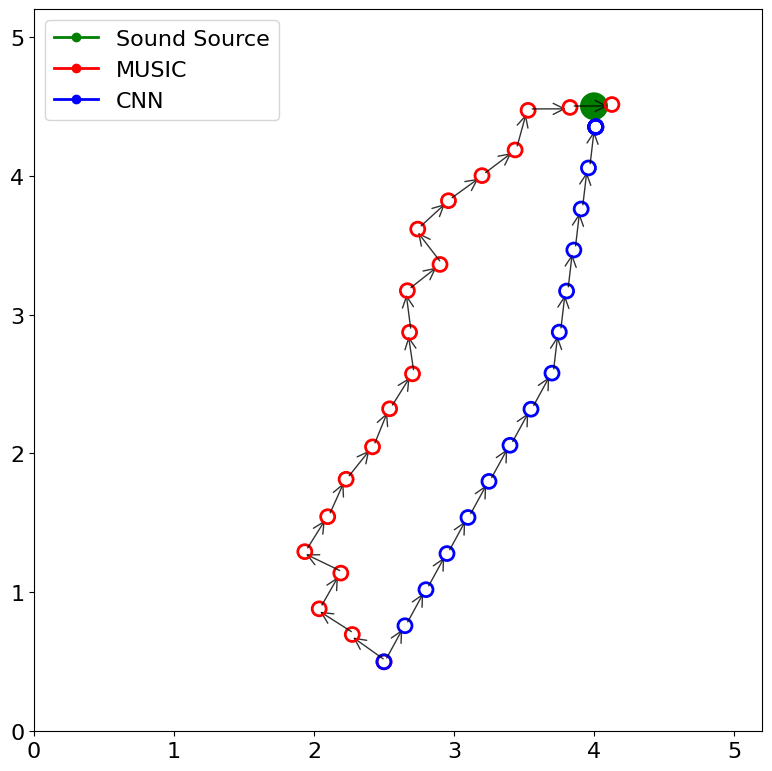

In [222]:
microphones = np.c_[[ROOM_DIM[0]/2-0.1, 0.5, 0], [ROOM_DIM[0]/2+0.1, 0.5, 0]]
source_loc = [float(4.), float(4.5)]
centre_mic = [2.5, 0.5]

plt.rcParams.update({'figure.figsize': [8,8], 'figure.autolayout': True, 'font.size': 16})
fig, _ = plt.subplots()
ax = plt.gca()
ax.set_xlim([0, 5.2])
ax.set_ylim([0, 5.2])

# Include sound source patch
sound = patches.Circle((float(source_loc[0]), float(source_loc[1])), radius=0.1, facecolor='green', linewidth=5, label='Sound Source')
ax.add_patch(sound)

# Include custom legend
legend_elements = [Line2D([0], [0], marker='o', color='green',  lw=2, label='Sound Source'),
                   Line2D([0], [0], marker='o', color='red',    lw=2, label='MUSIC'),
                   Line2D([0], [0], marker='o', color='blue',   lw=2, label='CNN')]
ax.legend(handles=legend_elements, loc='upper left')

# Initialize models
MUSIC = Model_pred('MUSIC', source_loc, centre_mic, 'red')
CNN = Model_pred('CNN', source_loc, centre_mic, 'blue')

# Generate predictions
while MUSIC.success == False or CNN.success == False:
    # Generate room
    fs, signal = wavfile.read(AUDIO_PATH)
    MUSIC.get_room(signal, ax)
    CNN.get_room(signal, ax)

    # Localize sound
    MUSIC.get_pred(ax)
    CNN.get_pred(ax)
    
    plt.show